In [ ]:
%pip install -Uq python-dotenv

from dotenv import load_dotenv
load_dotenv("../.env")

Note: you may need to restart the kernel to use updated packages.


True

In [ ]:
%pip install -Uq langgraph

Note: you may need to restart the kernel to use updated packages.


The state is going to be the constant data across your runs. We will define its schema here. In this case, it is going to be a simple string. In reality, this will encapsulate other important things, such as the mesasge history or its chain of thought.

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    my_state: str

### Nodes

These are simple python functions.
Each of them takes the state of your bot as input and returns a new state. Since we are passing the state, we can access the properties of the state within it and modify them. In this case, we can access the property "my_state".

Each node returns a new value of the state. Each time, we are actually overriding the state of the bot.

In [ ]:
def node_1(state):
  print(f"node_1: {state['my_state']}")
  new_state = {"my_state": state['my_state'] + "I want to travel to "}

  return new_state

def node_2(state):
  print(f"node_2: {state['my_state']}")
  new_state = {"my_state": state["my_state"] + "Germany!"}
  return new_state

def node_3(state):
  print(f"node_3: {state['my_state']}")
  new_state = {"my_state": state["my_state"] + "Italy!"}
  return new_state

### Edges

Edges are the connectors between nodes. There are two types of edges:
- Normal edges: Always connect two nodes.
- Conditional edges: Connect two nodes based on a condition.

To use conditional edges, you will need to define a function that will act as the condition.

In [ ]:
import random
from typing import Literal

def decide_destination(state: State) -> Literal["node_2", "node_3"]:
    return random.choice(["node_2", "node_3"])

### Connect the nodes

We can connect the nodes together

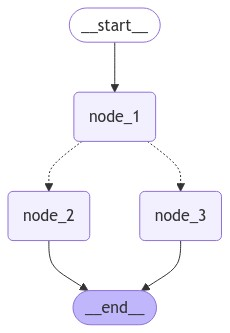

In [ ]:
# create our graph

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# build graph and add nodes
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# add edges
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_destination)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# compile
graph = builder.compile()

# view mermaid graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# a graph is a runnable

graph.invoke({
  "my_state": "Hello there. "
})

node_1: Hello there. 
node_2: Hello there. I want to travel to 


{'my_state': 'Hello there. I want to travel to Germany!'}

### Tool usage

In [ ]:
%pip install -Uq langchain langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import getpass

if "OPENAI_API_KEY" not in os.environ:
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """
    Multiply two numbers

    Args:
    a: The first number
    b: The second number
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o-mini")
tools = [multiply]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from pprint import pprint

pprint(llm_with_tools.__dict__)

{'bound': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x11f5ede50>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x11f5ef380>, root_client=<openai.OpenAI object at 0x11f475dc0>, root_async_client=<openai.AsyncOpenAI object at 0x11f475c70>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********')),
 'config': {},
 'config_factories': [],
 'custom_input_type': None,
 'custom_output_type': None,
 'kwargs': {'tools': [{'function': {'description': 'Multiply two numbers',
                                    'name': 'multiply',
                                    'parameters': {'properties': {'a': {'description': 'The '
                                                                                       'first '
                                                                                       'number',
                                                                        'type': 'integer'},
        

In [ ]:
# calling the model with the tools (no tool required)

response = llm_with_tools.invoke("what is a neural network?")
pprint(response.__dict__)

{'additional_kwargs': {'refusal': None},
 'content': 'A neural network is a computational model inspired by the way '
            'biological neural networks in the human brain process '
            'information. It consists of interconnected groups of nodes, or '
            '"neurons," which work together to solve specific problems. '
            "Here's a breakdown of its key components and principles:\n"
            '\n'
            '1. **Structure**:\n'
            '   - **Input Layer**: This layer receives the initial data or '
            'input features.\n'
            '   - **Hidden Layers**: One or more layers between the input and '
            'output layers where the processing occurs. Each neuron in these '
            'layers applies a transformation to the inputs it receives.\n'
            '   - **Output Layer**: This layer produces the final output or '
            'prediction based on the computations done in the previous '
            'layers.\n'
            '\n'
  

In [ ]:
# calling the model with the tools (tool required)

response = llm_with_tools.invoke("multiply 3 by 4")

In [ ]:
pprint(response.__dict__)

{'additional_kwargs': {'refusal': None,
                       'tool_calls': [{'function': {'arguments': '{"a":3,"b":4}',
                                                    'name': 'multiply'},
                                       'id': 'call_1ssjFiG8PZtOrEu3mJwmBUQr',
                                       'type': 'function'}]},
 'content': '',
 'example': False,
 'id': 'run-cc383c52-35b4-44ce-ae62-076d99b59f95-0',
 'invalid_tool_calls': [],
 'name': None,
 'response_metadata': {'finish_reason': 'tool_calls',
                       'logprobs': None,
                       'model_name': 'gpt-4o-mini-2024-07-18',
                       'system_fingerprint': 'fp_f59a81427f',
                       'token_usage': {'completion_tokens': 17,
                                       'completion_tokens_details': {'audio_tokens': None,
                                                                     'reasoning_tokens': 0},
                                       'prompt_tokens': 59,
       

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage

class MessagesState(TypedDict):
    messages: list[BaseMessage]

### Reducers (optional)

Remember that the value returned by a node overrides the state. That's why we were
appending new data to the state in the examples above.

Langgraph provides a way to do this without having to manually append data to the state. These are called reducers.

These are, essentially, just functions that tell langgraph how the state
should be updated when a new node returns something.

All you need to do is define a function that defines how the new data should be added to the state. A common pattern is to keep the LLM message history in the state. In this case, a useful reducer would be one that appends the new message to the history.

That's what the `add_messages` reducer does. It comes built-in with langgraph.

Langgraph uses a hack with `Annotated` to allow for passing a reducer to the graph.

In [ ]:
# from langgraph.graph.message import add_messages
# from typing_extensions import TypedDict, Annotated

# # langgraph uses a hack with Annotated to allow for reducer functions
# class MessagesState(TypedDict):
#     messages: Annotated[list[BaseMessage], add_messages]

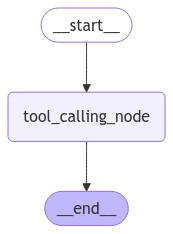

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage

initial_state = [
  AIMessage(content="Hello, I am Sherlock Holmes."),
  HumanMessage(content="Hi, I am John Watson. how do you solve a mystery?")
]

# node
def tool_calling_node(state: MessagesState):
    print("#" * 80)
    print("ENTERING LLM NODE - INPUT MESSAGES")

    for message in state["messages"]:
        message.pretty_print()
    response = llm_with_tools.invoke(state["messages"])

    print()
    print ("#" * 80)
    print("LEAVING LLM NODE - OUTPUT MESSAGES")

    response.pretty_print()

    return {"messages": response}

builder = StateGraph(MessagesState)

builder.add_node("tool_calling_node", tool_calling_node)
builder.add_edge(START, "tool_calling_node")
builder.add_edge("tool_calling_node", END)

graph = builder.compile()

# mermaid graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
graph_final = graph.invoke({
  "messages": initial_state
})

################################################################################
ENTERING LLM NODE - INPUT MESSAGES
================================== Ai Message ==================================

Hello, I am Sherlock Holmes.
================================ Human Message =================================

Hi, I am John Watson. how do you solve a mystery?

################################################################################
LEAVING LLM NODE - OUTPUT MESSAGES
================================== Ai Message ==================================

Ah, Dr. Watson! Solving a mystery, as you know, involves a systematic approach. Here’s how I typically proceed:

1. **Observation**: Pay close attention to the details. Everything matters, even the smallest clues.

2. **Gather Evidence**: Collect all available information, including witness statements, physical evidence, and any relevant documents.

3. **Analyze the Information**: Look for patterns, inconsistencies, and connections. This 

In [ ]:
for message in graph_final["messages"]:
    message.pretty_print()

================================== Ai Message ==================================

Hello, I am Sherlock Holmes.
================================ Human Message =================================

Hi, I am John Watson. how do you solve a mystery?
================================== Ai Message ==================================

Ah, Dr. Watson! Solving a mystery, as you know, involves a systematic approach. Here’s how I typically proceed:

1. **Observation**: Pay close attention to the details. Everything matters, even the smallest clues.

2. **Gather Evidence**: Collect all available information, including witness statements, physical evidence, and any relevant documents.

3. **Analyze the Information**: Look for patterns, inconsistencies, and connections. This often involves critical thinking and logical reasoning.

4. **Formulate Theories**: Based on the evidence, create hypotheses about what might have happened. 

5. **Test the Theories**: Seek further evidence that supports or disproves

In [ ]:
graph_final = graph.invoke({
  "messages": [
    HumanMessage(content="How much is 3 times 4?")
  ]
})

################################################################################
ENTERING LLM NODE - INPUT MESSAGES
================================ Human Message =================================

How much is 3 times 4?

################################################################################
LEAVING LLM NODE - OUTPUT MESSAGES
================================== Ai Message ==================================
Tool Calls:
  multiply (call_WBF62PIu96bmjfg8UrRCVHG2)
 Call ID: call_WBF62PIu96bmjfg8UrRCVHG2
  Args:
    a: 3
    b: 4


In [ ]:
for m in graph_final["messages"]:
    m.pretty_print()

================================ Human Message =================================

How much is 3 times 4?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_WBF62PIu96bmjfg8UrRCVHG2)
 Call ID: call_WBF62PIu96bmjfg8UrRCVHG2
  Args:
    a: 3
    b: 4


### Routing

We may need to route our flow to one of the nodes based on some condition. We can do this by defining a function that will act as the condition.

Let's do this for the function calls. If the LLM returns a function call, we will route the flow to a node that will execute the function. Else, we will continue with the normal flow.

A function like this would test if the last message in the history is a function call. If it is, it will send the flow to the function node. Else, it will continue with the normal flow.

Luckily, langgraph provides a built-in function for this. It is called `tools_condition`. The good news don't stop there. It also provides a built-in node that will execute the function. It is called `ToolNode`. Let's use them.

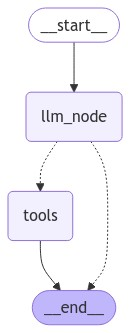

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

# define our tools
def multiply(a: int, b: int) -> int:
    """
    Multiply two numbers

    Args:
    a: The first number
    b: The second number
    """
    return a * b

tools = [multiply]

# define our llm and bind the tools
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

# node
def llm_node(state: MessagesState):
    print("#" * 80)
    print("ENTERING LLM NODE - INPUT MESSAGES")

    for message in state["messages"]:
        message.pretty_print()
    response = llm_with_tools.invoke(state["messages"])

    print()
    print ("#" * 80)
    print("LEAVING LLM NODE - OUTPUT MESSAGES")

    response.pretty_print()

    return {"messages": [response]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_node", llm_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_node")
builder.add_conditional_edges("llm_node", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()

# mermaid graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
graph_final = graph.invoke({
  "messages": [
    HumanMessage(content="How much is 3 times 4?")
  ]
})

################################################################################
ENTERING LLM NODE - INPUT MESSAGES
================================ Human Message =================================

How much is 3 times 4?

################################################################################
LEAVING LLM NODE - OUTPUT MESSAGES
================================== Ai Message ==================================
Tool Calls:
  multiply (call_OHJBcg7Njv5GjPMCEYjDjivM)
 Call ID: call_OHJBcg7Njv5GjPMCEYjDjivM
  Args:
    a: 3
    b: 4


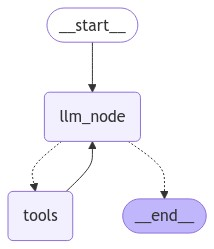

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

# define our tools
def celsius_to_fahrenheit(celsius: float) -> float:
    """
    Convert Celsius to Fahrenheit

    Args:
    celsius: The temperature in Celsius
    """
    return celsius * 9/5 + 32

def get_temperature(city: str) -> float:
    """
    Get the temperature of a city in Celsius

    Args:
    city: The name of the city
    """
    if city.lower() == "berlin":
        return 20
    if city.lower() == "paris":
        return 22
    if city.lower() == "san francisco":
        return 25
    return 30

tools = [celsius_to_fahrenheit, get_temperature]

# define our llm and bind the tools
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

# node
def llm_node(state: MessagesState):
    print("#" * 80)
    print("ENTERING LLM NODE - INPUT MESSAGES")

    for message in state["messages"]:
        message.pretty_print()
    response = llm_with_tools.invoke(state["messages"])

    print()
    print ("#" * 80)
    print("LEAVING LLM NODE - OUTPUT MESSAGES")

    response.pretty_print()

    return {"messages": [response]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("llm_node", llm_node)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_node")
builder.add_conditional_edges("llm_node", tools_condition)
builder.add_edge("tools", "llm_node")

graph = builder.compile()

# mermaid graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
graph_final = graph.invoke({
  "messages": [
    HumanMessage(content="What is the temperature of paris in fahrenheit?")
  ]
})

################################################################################
ENTERING LLM NODE - INPUT MESSAGES
================================ Human Message =================================

What is the temperature of paris in fahrenheit?

################################################################################
LEAVING LLM NODE - OUTPUT MESSAGES
================================== Ai Message ==================================
Tool Calls:
  get_temperature (call_7kYaXS1EsfB3fR6Fh8tWwq31)
 Call ID: call_7kYaXS1EsfB3fR6Fh8tWwq31
  Args:
    city: Paris
################################################################################
ENTERING LLM NODE - INPUT MESSAGES
================================ Human Message =================================

What is the temperature of paris in fahrenheit?
================================== Ai Message ==================================
Tool Calls:
  get_temperature (call_7kYaXS1EsfB3fR6Fh8tWwq31)
 Call ID: call_7kYaXS1EsfB3fR6Fh8tWwq31
 

In [ ]:
for m in graph_final["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the temperature of paris in fahrenheit?
================================== Ai Message ==================================
Tool Calls:
  get_temperature (call_7kYaXS1EsfB3fR6Fh8tWwq31)
 Call ID: call_7kYaXS1EsfB3fR6Fh8tWwq31
  Args:
    city: Paris
================================= Tool Message =================================
Name: get_temperature

22
================================== Ai Message ==================================
Tool Calls:
  celsius_to_fahrenheit (call_FccAiMyiNOoCUMvrTD5ZpP8B)
 Call ID: call_FccAiMyiNOoCUMvrTD5ZpP8B
  Args:
    celsius: 22
================================= Tool Message =================================
Name: celsius_to_fahrenheit

71.6
================================== Ai Message ==================================

The temperature in Paris is 71.6°F.
